In [ ]:
from mmassist.model import build_from_checkpoint
from mmassist.configs import parse_args

# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul1-L2048-I10-lr2e-4-bs64-ep4"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul3-L8192-I1-lr2e-4-bs64-ep2"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul4-L2048-I1-lr2e-4-bs64-ep10"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul11-livechat-L2048-I1-lr2e-4-bs64-ep2-resume"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul13-L8192-I1-lr2e-4-bs64-ep2-rpad"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul13-L2048-I1-lr2e-4-bs64-ep2-NOSEP"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul13-L2048-I10-lr2e-4-bs192-ep2-rpad"
ckpt = "/fsx_0/user/imzyc/proact_exps/Jul13-L2048-I1-lr2e-4-bs64-ep2-rpad"
# ckpt = "/fsx_0/user/imzyc/proact_exps/Jul23-debug-lora"

model, tokenizer = build_from_checkpoint(ckpt)
model.device

In [6]:
from mmassist.data import build_eval_datasets, ProActCollator

config = model.config

# the original model arguments
all_args_dict = config.to_dict()
all_args_dict.update(config.training_args)
print(config.training_args["eval_datasets"])
dataset_dict = build_eval_datasets(**all_args_dict, keep_images=True)
dataset = list(dataset_dict.values())[0]

chat_formatter = tokenizer.chat_formatter
collator = ProActCollator(tokenizer, chat_formatter)

video = dataset[1]

ego4d/narration_goalstep_val_L2048_I1+SEP
Evaluation datasets:
* ego4d/narration_goalstep_val | num samples: 480



In [5]:
from mmassist.data import build_train_dataset, ProActCollator

config = model.config

# the original model arguments
# train_datasets = "ego4d/narration_train_L2048_I1+SEP,llava/caption_L2048_I1"
train_datasets = "ego4d/dialog_val_L2048_I1+SEP"
all_args_dict["train_datasets"] = train_datasets
dataset= build_train_dataset(**all_args_dict)

chat_formatter = tokenizer.chat_formatter
collator = ProActCollator(tokenizer, chat_formatter)

video = dataset[1]

NameError: name 'model' is not defined

In [13]:
len(dataset)

65276

In [9]:
video["encoded_images"].shape

torch.Size([105, 1152])

In [6]:
from mmassist.data import build_train_dataset
from mmassist.configs.arguments import parse_args
from mmassist.model.tokenization_proact import build_tokenizer_and_update_config, ProActConfig
from mmassist.eval.runners.stream_inference import StreamProcessor, FrameOutput, annotate_and_save_video

model_args, train_args = parse_args()
model_args.max_seq_len = 2048
model_args.img_patch_token_size = 0
dataset_name = "holoassist"
train_args.train_datasets = f"{dataset_name}/dialog_train_L2048_I1+SEP"
all_args_dict = {**model_args.to_dict(), **train_args.to_dict()}

dataset= build_train_dataset(**all_args_dict, keep_images=True)
config = ProActConfig.from_dict(model_args.to_dict())
tokenizer = build_tokenizer_and_update_config(config)

processor = StreamProcessor(tokenizer, tokenizer.chat_formatter, fps=2)

dataset = dataset.datasets[0]
# dataset.img_feature_dir = ""
raw_data = dataset.data

Training datasets:
* holoassist/dialog_train_L2048_I1+SEP@1 | num samples: 26142
Total training data size: 26.1K


In [7]:
import os
import random
os.environ["TOKENIZERS_PARALLELISM"] = "false"

exists = set()
indexes = list(range(len(dataset)))
random.shuffle(indexes)
# for idx in range(len(dataset)):
cnt = 0
for idx in indexes:
    video = dataset[idx]
    sample = raw_data[idx]
    video_uid = sample["video_uid"]
    metadata = sample["metadata"]
    user_type = metadata["user_type"]
    goal = metadata['task_goal'].replace(" ", "_")
    print(idx, sample["video_uid"], goal, user_type)

    if metadata["quality"] < 5:
        continue

    if "0" not in metadata["user_id"]:
        continue

    if not metadata["has_summary"]:
        print("no summary")
        continue
    
    save_dir = f"videos_0813"
    os.makedirs(save_dir, exist_ok=True)
    save_file = f"{save_dir}/{dataset_name}_{video_uid}_{idx}_{goal}_{user_type}.mp4"
    # if os.path.exists(save_file) or f"{video['video_id']}_{goal}_{user_type}" in exists:
    #     continue
    exists.add(f"{dataset_name}_{video_uid}_{goal}_{user_type}")
    
    # process to the stream format
    streams = processor.processed_conv_data_to_stream(video)
    outputs = []
    for frame_idx, frames in enumerate(streams):
        # cleaned_usr_text, role = processor.cleanup_text(frames.input_str)
        text_inputs = [(t["role"], t["content"]) for t in frames.input_messsages]
        cleaned_ass_text = processor.cleanup_text(frames.ref_output_str)[0]
        outputs.append(
            FrameOutput(
                gen="",
                ref=cleaned_ass_text,
                image=frames.images[0],
                text_inputs=text_inputs,
                frame_idx_in_stream=frames.frame_idxs_in_stream[0],
                frame_idx_in_original_video=frames.frame_idxs_in_original_video[0],
                timestamp_in_stream=frames.timestamps[0],
            ).to_dict(ignore_keys="")
        )

        if frame_idx > 720:
            break
    
    annotate_and_save_video(outputs, save_file, fps=4, assistant_name_gt="assistant")
    cnt += 1
    if cnt > 2:
        break

16671 z169-sep-02-22-knarrevik_disassemble Disassembling_a_Nightstand_into_its_Component_Parts talk_some


KeyError: 'quality'

In [6]:
video

{'dataset': 'ego4d/dialog_train_L2048_I1+SEP',
 'sample_idx': 14114,
 'video_uid': '4a36b555-865b-43ad-ba27-cf022521bb6d',
 'conversation': [{'role': 'system',
   'content': "You are a helpful assistant. Be responsive to the user's questions, and provide useful information proactively when needed.",
   'start': None,
   'end': None,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'frames',
   'content': None,
   'start': 0,
   'end': 1,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'user',
   'content': 'I want to prepare boiled or blanched Japanese Mustard Greens with homemade salad dressing.',
   'start': None,
   'end': None,
   'time': 0.0,
   'labels': '',
   'progress': None},
  {'role': 'system',
   'content': 'Task knowledge: Preparing Boiled or Blanched Japanese Mustard Greens with Homemade Salad Dressing\n\n1. Boil water in a pot.\n2. Wash, cut, and slice the Japanese mustard greens.\n3. Prepare a homemade salad dressing by mixing i

In [4]:
frames.input_messsages

[{'role': 'system',
  'content': "You are a proactive assistant. Pay close attention to the user's actions and provide relevant information proactively.",
  'start': None,
  'end': None,
  'time': None,
  'labels': None,
  'progress': None},
 {'role': 'user',
  'content': 'I want to prepare chicken and vegetable filling for tacos.',
  'start': None,
  'end': None,
  'time': 4.8,
  'labels': '',
  'progress': None},
 {'role': 'system',
  'content': 'Task knowledge: Preparing Chicken and Vegetable Filling for Tacos\n1. Shred the chicken into pieces.\n2. Blend the vegetables (including green pepper, onions, and tomatoes) with a hand blender.\n3. Heat a pan with oil on an electric cooker.\n4. Combine the blended vegetable mixture with the shredded chicken and cook in the heated pan.',
  'start': None,
  'end': None,
  'time': None,
  'labels': None,
  'progress': None}]

In [15]:
import datasets as hf_datasets
feature_file = (
    ""
    if dataset.img_feature_dir is None
    else os.path.join(dataset.img_feature_dir, f"7fb63b81-0a4f-4e9e-906b-60d1935d53c7.arrow")
)
features = hf_datasets.Dataset.from_file(feature_file)
features = features.with_format("torch", columns=dataset.img_feature_keys)

frames_file = os.path.join(dataset.data_dir, sample["frames_file"])
all_frames_in_video = hf_datasets.Dataset.from_file(frames_file)

In [18]:
features

Dataset({
    features: ['original_idx', 'sampled_idx', 'cls', '2x2', '3x3', '5x5'],
    num_rows: 1417
})

In [16]:
all_frames_in_video.shape

(4251, 1)

In [11]:
dataset.data[idx]

{'video_id': '7fb63b81-0a4f-4e9e-906b-60d1935d53c7',
 'original_fps': None,
 'sample_fps': 2,
 'frames_file': 'frames/7fb63b81-0a4f-4e9e-906b-60d1935d53c7.arrow',
 'max_seq_len': 2048,
 'use_img_cls_token': True,
 'use_img_sep_token': True,
 'num_tokens_per_img': 1,
 'start_frame_idx': 4163,
 'end_frame_idx': 4687,
 'user_type': 'no_talk',
 'task_goal': 'Preparing a Cold Noodle Dish with Various Toppings',
 'knowledge': 'Preparing a Cold Noodle Dish with Various Toppings\n1. Prepare ingredients: arrange eggs, vegetables (e.g., negi onions, cucumbers, tomatoes), seafood, and sauce on the counter top.\n2. Boil eggs and let them cool.\n3. Cut and slice vegetables (negi onions, cucumber, tomatoes) and seafood.\n4. Soak and slice leaves (likely for garnish).\n5. Boil noodles according to package instructions and cool them down.\n6. Dilute sauce with cold water in a bowl.\n7. Stir and mix ingredients (eggs, vegetables, seafood) with the diluted sauce.\n8. Serve noodles in a bowl with the mix

In [6]:
video["conversation"]

[{'role': 'system',
  'content': 'You are a supportive assistant. Always be ready to help and offer useful advice without being asked.',
  'start': None,
  'end': None,
  'time': None,
  'labels': None,
  'progress': None},
 {'role': 'frames',
  'content': None,
  'start': 0,
  'end': 381,
  'time': None,
  'labels': None,
  'progress': None},
 {'role': 'user',
  'content': 'I want to prepare multiple seafood and pasta dishes. Can you guide me through it?',
  'start': None,
  'end': None,
  'time': 190.7,
  'labels': '',
  'progress': None},
 {'role': 'frames',
  'content': None,
  'start': 380,
  'end': 381,
  'time': None,
  'labels': None,
  'progress': None},
 {'role': 'system',
  'content': 'Task knowledge: Preparing Multiple Seafood and Pasta Dishes\n1. Fry fish in an air fryer.\n2. Prepare ingredients: dice spring onions, slice meat, wash and slice cucumber.\n3. Prepare shrimps: wash and slice.\n4. Slice the cooked fish.\n5. Grate ginger and store it in the fridge.\n6. Boil wate

In [7]:
video["encoded_images"].shape, video["images"].shape

(torch.Size([797, 1152]), torch.Size([797, 3, 384, 384]))

In [9]:
video["start_frame_idx"], video["end_frame_idx"]

(0, 797)

In [4]:
video

{'dataset': 'ego4d/dialog_val_L2048_I1+SEP',
 'sample_idx': 1432,
 'video_id': 'd8f0089b-cac5-41f4-af66-e11d6f54a43c',
 'conversation': [{'role': 'system',
   'content': 'You are a supportive assistant. Always be ready to help and offer useful advice without being asked.',
   'start': None,
   'end': None,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'frames',
   'content': None,
   'start': 0,
   'end': 381,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'user',
   'content': 'I want to prepare multiple seafood and pasta dishes. Can you guide me through it?',
   'start': None,
   'end': None,
   'time': 190.7,
   'labels': '',
   'progress': None},
  {'role': 'frames',
   'content': None,
   'start': 380,
   'end': 381,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'system',
   'content': 'Task knowledge: Preparing Multiple Seafood and Pasta Dishes\n1. Fry fish in an air fryer.\n2. Prepare ingredients: dice spring on

In [16]:
# load jsonl
import json
import os
from mmassist.model.tokenization_proact import LLaMA3MultimodalChat

df = "/fsx_0/user/imzyc/processed_data/llava/prepared/caption_L8192_I10+SEP.jsonl"
with open(df, "r") as f:
    data = [json.loads(line) for line in f]
chat_formatter1 = LLaMA3MultimodalChat(img_token="<image>", num_tokens_per_img=10, sep_token="<SEP>")
chat_formatter1.apply_chat_template(data[0]["conversation"])

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nProvide a concise description of the image.<|eot_id|><image><image><image><image><image><image><image><image><image><image><|start_header_id|>assistant<|end_header_id|>\n\n2012 chevrolet equinox for sale at santa fe auto showcase in mesa az<|eot_id|><image><image><image><image><image><image><image><image><image><image><|start_header_id|>assistant<|end_header_id|>\n\na cat looking at a halloween skeleton<|eot_id|><image><image><image><image><image><image><image><image><image><image><|start_header_id|>assistant<|end_header_id|>\n\na card featuring an abstract, hand lettered text, on top of a beige card that says love you<|eot_id|><image><image><image><image><image><image><image><image><image><image><|start_header_id|>assistant<|end_header_id|>\n\ntwo korean beaus meet for the first time in a marriage episode<|eot_id|><image><image><image><image><image><image><image><image><image><image><|start_header_id|>assistant<|end_heade

In [9]:
from mmassist.eval.runners.stream_inference import StreamInferenceRunner, FrameOutput
runner = StreamInferenceRunner.build(model, tokenizer, eval_name="debug")
runner.not_talk_threshold = 0.7


In [10]:
for i in range(3,4):
    video = dataset[i]
    outputs = runner.run_inference_on_video(
        video,
        use_gt_context=True,
        verbose=True,
        video_output_dir="",
        max_time=60,
    )
    # print("VIDEO:", video["video_id"], video["sample_idx"])
    # for i in outputs:
    #     if i.gen or i.ref:
    #         print(i.frame_idx_in_stream)
    #         print("REF:", i.ref)
    #         print("GEN:", i.gen)
    #         print("--------")

[0.5s] USER: Elaborate on the camera wearer's interactions with their environment.
[0.5s] REF : 
[0.5s] GEN : 
[1.0s] REF : 
[1.0s] GEN : 
[1.5s] REF : 
[1.5s] GEN : The camera wearer puts the plate in the sink.
[2.0s] REF : The camera wearer pours the water in the other glass cup into the sink.
[2.0s] GEN : The camera wearer puts the cup in the sink.
[2.5s] REF : 
[2.5s] GEN : 
[3.0s] REF : 
[3.0s] GEN : 
[3.5s] REF : The camera wearer drops the other glass cup in the dishwasher.
[3.5s] GEN : The camera wearer opens the dishwasher.
[4.0s] REF : 
[4.0s] GEN : 
[4.5s] REF : 
[4.5s] GEN : 
[5.0s] REF : 
[5.0s] GEN : 
[5.5s] REF : 
[5.5s] GEN : 
[6.0s] REF : 
[6.0s] GEN : 
[6.5s] REF : 
[6.5s] GEN : 
[7.0s] REF : 
[7.0s] GEN : 
[7.5s] REF : The camera wearer picks another glass cup from the sink with her right hand.
[7.5s] GEN : The camera wearer picks the other glass cup from the sink.
[8.0s] REF : 
[8.0s] GEN : 
[8.5s] REF : 
[8.5s] GEN : 
[9.0s] REF : The camera wearer drops the other 

In [ ]:
import os
import json
import torch
import sentence_transformers as sbert
from dataclasses import dataclass
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching


@torch.no_grad()
def get_semantic_match_cost(
    strings: list[tuple[str, str]], model: sbert.SentenceTransformer, **kwargs
) -> torch.Tensor:
    """Calculate the semantic text similarity cost between two lists of strings.

    :param strings: list of tuples of strings to compute similarity between
    :param model: a sentence transformer model for computing sentence embeddings

    :return: tensor of semantic text similarity cost which
        is the negative log of the cosine similarity between the embeddings
    """
    all_strings = [s for pair in strings for s in pair]
    embeddings = model.encode(
        all_strings, convert_to_tensor=True, show_progress_bar=False, **kwargs
    )
    embeddings = embeddings.view(len(strings), 2, -1)
    cos_sim = sbert.util.pairwise_cos_sim(embeddings[:, 0], embeddings[:, 1])
    score = (cos_sim + 1) / 2
    return -torch.log(score.clamp(min=1e-6))


def mask_local_cost(
    cost: torch.Tensor, window_size: int, masked_cost: float = torch.inf
) -> torch.Tensor:
    h, w = cost.shape
    mask = torch.range(1, h)[:, None] - torch.range(1, w)
    cost[mask.abs() > window_size] = masked_cost
    return cost


def get_text_match_cost(
    eval_outputs: list[FrameOutput],
    sts_model: sbert.SentenceTransformer | None,
    window_size: int,
    no_talk_str: str = "",
    **kwargs,
) -> torch.Tensor:

    gen_talk_times = torch.tensor(
        [-1.0 if o.gen == no_talk_str else 1.0 for o in eval_outputs]
    )
    ref_talk_times = torch.tensor(
        [-1.0 if o.ref == no_talk_str else 1.0 for o in eval_outputs]
    )
    cost = -gen_talk_times[None].T @ ref_talk_times[None]
    cost = (cost + 1) / 2

    if sts_model is not None:
        ws = window_size
        cmp_ids = []
        cmp_texts = []
        for i, fi in enumerate(eval_outputs):
            gen_txt = fi.gen
            if gen_txt != no_talk_str:
                for j in range(max(i - ws, 0), min(i + ws + 1, len(eval_outputs))):
                    ref_txt = eval_outputs[j].ref
                    if ref_txt != no_talk_str:
                        cmp_ids.append((i, j))
                        cmp_texts.append((gen_txt, ref_txt))

        sem_costs = get_semantic_match_cost(cmp_texts, sts_model, **kwargs)
        for (i, j), c in zip(cmp_ids, sem_costs):
            cost[i, j] = c

    cost = mask_local_cost(cost, window_size)
    return cost, gen_talk_times


def get_distance_cost(
    h: int, w: int, power: float = 1.5, multiplier: float = 1.0
) -> torch.Tensor:
    dist = torch.range(1, h)[:, None] - torch.range(1, w)
    dist = dist.abs().float()
    return (dist**power) * multiplier


@dataclass
class MatchResult:
    matched: list[tuple[FrameOutput, FrameOutput]]
    missed: list[FrameOutput]
    redundant: list[FrameOutput]
    match_costs: list[float]

    @classmethod
    def from_json(cls, d: dict) -> "MatchResult":
        return cls(
            matched=[(FrameOutput(**g), FrameOutput(**r)) for g, r in d["matched"]],
            missed=[FrameOutput(**m) for m in d["missed"]],
            redundant=[FrameOutput(**m) for m in d["redundant"]],
            match_costs=d["match_costs"],
        )

    def to_json(self) -> dict:
        return {
            "matched": [(g.to_dict(), r.to_dict()) for g, r in self.matched],
            "missed": [m.to_dict() for m in self.missed],
            "redundant": [m.to_dict() for m in self.redundant],
            "match_costs": self.match_costs,
        }

    def save_json(self, path: str) -> None:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            json.dump(self.to_json(), f, indent=2)


def find_match(
    eval_outputs: list[FrameOutput],
    sts_model: sbert.SentenceTransformer | None,
    window_size: int = 2,
    dist_func_factor: float = 0.1,
    dist_func_power: float = 1.5,
    no_talk_str: str = "",
    **kwargs,
) -> MatchResult:

    match_cost, gen_talk_ids = get_text_match_cost(
        eval_outputs,
        sts_model,
        window_size=window_size,
        no_talk_str=no_talk_str,
        **kwargs,
    )
    print(match_cost)

    multiplier = dist_func_factor / (window_size ** dist_func_power)
    dist_cost = get_distance_cost(
        *match_cost.shape, power=dist_func_power, multiplier=multiplier
    )
    print(dist_cost)

    total_cost = match_cost + dist_cost
    gen_talk_pos_mask = gen_talk_ids == 1
    gen_talk_indices = gen_talk_pos_mask.nonzero().flatten()
    gen_to_ref_costs = total_cost[gen_talk_pos_mask]

    gen_to_ref_costs_csr = csr_matrix(gen_to_ref_costs.numpy())

    idx_in_gen_talk, idx_in_ref = min_weight_full_bipartite_matching(
        gen_to_ref_costs_csr
    )
    idx_in_gen = gen_talk_indices[idx_in_gen_talk].numpy()
    gen_to_ref_match = {i: j for i, j in zip(idx_in_gen, idx_in_ref)}
    ref_be_matched = set(idx_in_ref)

    for i, j in zip(idx_in_gen, idx_in_ref):
        print(f"gen {i}: {eval_outputs[i].gen}")
        print(f"-> ref {j}: {eval_outputs[j].ref}")
        print(
            f"    total_cost: {total_cost[i, j]:.3f}, match_cost: {match_cost[i, j]:.3f}, dist_cost: {dist_cost[i, j]:.3f}"
        )

    matched, missed, redundant, match_costs = [], [], [], []
    for i, f in enumerate(eval_outputs):
        if i in gen_to_ref_match:
            ref_frame = eval_outputs[gen_to_ref_match[i]]
            if ref_frame.ref != no_talk_str:
                matched.append((f, eval_outputs[gen_to_ref_match[i]]))
                match_costs.append(total_cost[i, gen_to_ref_match[i]].cpu().item())
            else:
                redundant.append(f)
        if f.ref != no_talk_str and i not in ref_be_matched:
            missed.append(f)

    return MatchResult(
        matched=matched,
        missed=missed,
        redundant=redundant,
        match_costs=match_costs,
    )



torch.set_printoptions(precision=3, sci_mode=False)
model_name = "sentence-transformers/all-mpnet-base-v2"
sts_model = sbert.SentenceTransformer(model_name, device="cuda")

test_outputs = [
    FrameOutput(gen="", ref="Hi"),
    FrameOutput(gen="Hello", ref=""),
    FrameOutput(gen="", ref=""),
    FrameOutput(gen="A boy is running.", ref="A cat is chasing the ball."),
    FrameOutput(gen="", ref="A boy is running fast."),
    FrameOutput(gen="A cat is playing with the ball.", ref=""),
    FrameOutput(gen="", ref=""),
    FrameOutput(gen="A boy is running fast.", ref=""),
]
# test_outputs = [
#     FrameOutput(gen="", ref="Hi"),
#     FrameOutput(gen="Hello", ref=""),
#     FrameOutput(gen="", ref=""),
#     FrameOutput(gen="A boy is running.", ref="A cat is chasing the ball."),
#     FrameOutput(gen="", ref="A boy is running fast."),
#     FrameOutput(gen="", ref=""),
#     FrameOutput(gen="", ref=""),
#     FrameOutput(gen="", ref=""),
# ]

from mmassist.eval.stream_inference import load_predictions
# test_outputs, _ = load_predictions("/data/home/imzyc/project/proactive-assist/notebooks/ego4d/livechat_goalstep_val_L2048_I1+SEP/0_gtctx.json")

match_result = find_match(
    test_outputs,
    sts_model=sts_model,
    window_size=2,
    dist_func_factor=0.2,
    dist_func_power=1.5,
    batch_size=128,
)
match_result.save_json("./test_match_result.json")

tensor([[1.000, 0.000, 0.000,   inf,   inf,   inf,   inf,   inf],
        [0.072, 1.000, 1.000, 0.735,   inf,   inf,   inf,   inf],
        [1.000, 0.000, 0.000, 1.000, 1.000,   inf,   inf,   inf],
        [  inf, 1.000, 1.000, 0.490, 0.034, 1.000,   inf,   inf],
        [  inf,   inf, 0.000, 1.000, 1.000, 0.000, 0.000,   inf],
        [  inf,   inf,   inf, 0.077, 0.611, 1.000, 1.000, 1.000],
        [  inf,   inf,   inf,   inf, 1.000, 0.000, 0.000, 0.000],
        [  inf,   inf,   inf,   inf,   inf, 1.000, 1.000, 1.000]])
tensor([[0.000, 0.071, 0.200, 0.367, 0.566, 0.791, 1.039, 1.310],
        [0.071, 0.000, 0.071, 0.200, 0.367, 0.566, 0.791, 1.039],
        [0.200, 0.071, 0.000, 0.071, 0.200, 0.367, 0.566, 0.791],
        [0.367, 0.200, 0.071, 0.000, 0.071, 0.200, 0.367, 0.566],
        [0.566, 0.367, 0.200, 0.071, 0.000, 0.071, 0.200, 0.367],
        [0.791, 0.566, 0.367, 0.200, 0.071, 0.000, 0.071, 0.200],
        [1.039, 0.791, 0.566, 0.367, 0.200, 0.071, 0.000, 0.071],
        [

In [ ]:
from mmassist.eval.metrics.nlg_scorer import NLGEval
nlg_scorer = NLGEval()

In [ ]:
hyps, refs = {}, {}
for idx, (g, r) in enumerate(match_result.matched):
    hyps[idx] = g.gen
    refs[idx] = [r.ref]

scores = nlg_scorer.compute_metrics(refs, hyps)

In [ ]:
our_metrics = {}
num_matched = len(match_result.matched)
num_missed = len(match_result.missed)
num_redundant = len(match_result.redundant)
jaccard = num_matched / (num_matched + num_missed + num_redundant)
our_metrics["jaccard_index"] = jaccard
for s_name, s in scores.items():
    our_metrics[f"tms_{s_name}"] = s
    our_metrics[f"wtms_{s_name}"] = s * jaccard

our_metrics

{'jaccard_index': 0.75,
 'tms_Bleu_1': 0.7499999998750001,
 'wtms_Bleu_1': 0.5624999999062501,
 'tms_Bleu_2': 0.7071067810588756,
 'wtms_Bleu_2': 0.5303300857941566,
 'tms_Bleu_3': 0.5984084804714268,
 'wtms_Bleu_3': 0.44880636035357013,
 'tms_Bleu_4': 0.4549941403057705,
 'wtms_Bleu_4': 0.3412456052293279,
 'tms_CIDEr': 3.8493007421726273,
 'wtms_CIDEr': 2.8869755566294706,
 'tms_METEOR': 0.39886864138736616,
 'wtms_METEOR': 0.29915148104052464}

In [ ]:
# score * (|A| / |A| + |B| + |C|)

In [ ]:
import os
import json
import torch
import numpy as np
import sentence_transformers as sbert

from transformers import PreTrainedTokenizer

from mmassist.eval.runners import StreamInferenceRunner
from mmassist.data.dataset import BaseDataset
from mmassist.eval.evaluators.pred_match import find_match, MatchResult
from mmassist.eval.metrics.nlg_scorer import NLGEval
from mmassist.eval.eval_multijob import EvalArguments
from mmassist.model import build_from_checkpoint

class StreamEvaluator:
    def __init__(
        self,
        model_path: str,
        dataset: BaseDataset,
        nlg_scorer: NLGEval,
        nlg_metrics: tuple[str] = ("Bleu", "CIDEr", "METEOR"),
        use_gt_context: bool = False,
        fps: int = 2,
        sts_model_type: str ="sentence-transformers/all-mpnet-base-v2",
        match_window_time: float = 1.0,
        match_dist_func_factor: float = 0.2,
        match_dist_func_power: float = 1.5,
        sts_eval_batch_size: int = 128,
        force_rerun: bool = False,
        model: torch.nn.Module | None = None,
        tokenizer: PreTrainedTokenizer | None = None,
        inference_runner: StreamInferenceRunner | None = None,
        device: str | None = None,
        **kwargs,
    ):
        self.model_path = model_path
        self.dataset = dataset
        self.dataset_name = dataset.dataset_name
        self.nlg_scorer = nlg_scorer
        self.nlg_metrics = list(nlg_metrics)
        self.use_gt_context = use_gt_context
        self.sts_model_type = sts_model_type
        self.sts_model = None
        self.sts_eval_batch_size = sts_eval_batch_size
        self.fps = fps
        self.match_window_time = match_window_time
        self.match_window_size = int(match_window_time * fps)
        self.match_dist_func_factor = match_dist_func_factor
        self.match_dist_func_power = match_dist_func_power
        self.model = model
        self.tokenizer = tokenizer
        self.inference_runner = inference_runner
        self.device = device
        self.force_rerun = force_rerun
        self.set_save_dirs()

    @classmethod
    def build(cls, dataset: BaseDataset, **kwargs) -> "StreamEvaluator":
        return cls(dataset=dataset, nlg_scorer=NLGEval(), **kwargs)

    def build_sts_model(self) -> None:
        if self.device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.sts_model = sbert.SentenceTransformer(self.sts_model_type,  device=self.device)
    

    def build_inference_runner(self) -> StreamInferenceRunner:
        if self.model is None or self.tokenizer is None:
            self.model, self.tokenizer = build_from_checkpoint(self.model_path)
        return StreamInferenceRunner.build(self.model, self.tokenizer, fps=self.fps)

    def set_save_dirs(self):
        """Set the save directories for the inference results and metrics.

        Folder stucture:
        model_path
        |-- eval
            |-- results
            |   |-- {dataset}
            |       |-- {sample_id}.json
            |       |-- ...
            |-- metrics
            |   |-- {dataset}
            |       |-- {sample_id}.json
            |       |-- ...
            |-- {metric}_{dataset}_args.json
            |-- {metric}_{dataset}_metrics.json
            |-- ...

        Metric summarization across models storaged in a shared directory:
        {dataset}_{metric}.txt
        """
        self.eval_dir = os.path.join(self.model_path, "eval")
        self.result_dir = os.path.join(self.eval_dir, "results")
        self.metric_dir = os.path.join(self.eval_dir, "metrics")
        os.makedirs(self.result_dir, exist_ok=True)
        os.makedirs(self.metric_dir, exist_ok=True)

    def compute_metrics_on_video(self, sample_idx: int, **kwargs) -> dict:
        pred_file = StreamInferenceRunner.get_result_file_path(
            self.result_dir, self.dataset_name, sample_idx, self.use_gt_context
        )
        if os.path.exists(pred_file) and not self.force_rerun:
            predictions, _ = StreamInferenceRunner.load_predictions(pred_file)
        else:
            if self.inference_runner is None:
                # lazy build the inference runner
                self.inference_runner = self.build_inference_runner()
            predictions = self.inference_runner.run_inference_on_video(
                self.dataset[sample_idx],
                use_gt_context=self.use_gt_context,
                output_dir=self.result_dir,
                **kwargs,
            )

        # find the match between predictions and ground truth
        match_result_file = pred_file.replace("/results/", "/results_match/")
        if os.path.exists(match_result_file) and not self.force_rerun:
            match_result = MatchResult.from_json(json.load(open(match_result_file)))
        else:
            if self.sts_model is None:
                self.build_sts_model()
            match_result = find_match(
                predictions,
                sts_model=self.sts_model,
                window_size=self.match_window_size,
                dist_func_factor=self.match_dist_func_factor,
                dist_func_power=self.match_dist_func_power,
                batch_size=self.sts_eval_batch_size,
            )

        # compute NLG scores
        hyps, refs = {}, {}
        for idx, (g, r) in enumerate(match_result.matched):
            hyps[idx] = g.gen
            refs[idx] = [r.ref]
        scores = self.nlg_scorer.compute_metrics(refs, hyps, metrics=self.nlg_metrics)

        # compute stream metrics
        num_matched = len(match_result.matched)
        num_missed = len(match_result.missed)
        num_redundant = len(match_result.redundant)
        match_cost = np.mean(match_result.match_costs)
        jaccard = num_matched / (num_matched + num_missed + num_redundant)
        metrics = {
            "num_matched": num_matched,
            "num_missed": num_missed,
            "num_redundant": num_redundant,
            "match_cost": match_cost,
            "jaccard_index": jaccard,
        }
        for s_name, s in scores.items():
            metrics[f"tms_{s_name}"] = s
            metrics[f"wtms_{s_name}"] = s * jaccard

        # save the metrics
        metric_file = StreamInferenceRunner.get_result_file_path(
            self.metric_dir, self.dataset_name, sample_idx, self.use_gt_context
        )
        with open(metric_file, "w") as f:
            json.dump(metrics, f, indent=2)

        return metrics

    def compute_metrics(self, sample_indices: list[int], **kwargs) -> dict:
        all_metrics = {}
        for idx in sample_indices:
            metrics = self.compute_metrics_on_video(idx, **kwargs)
            all_metrics[idx] = metrics

        return all_metrics

    def gather_metrics(self, all_metrics: dict | None = None) -> dict:
        if all_metrics is None:
            metric_file = StreamInferenceRunner.get_result_file_path(
                self.metric_dir, self.dataset_name, 0, self.use_gt_context
            )
            metric_dir = os.path.dirname(metric_file)
            all_metrics = {}
            for file in os.listdir(metric_dir):
                if file.endswith(".json"):
                    with open(os.path.join(metric_dir, file)) as f:
                        metrics = json.load(f)
                        all_metrics[int(file.split(".")[0])] = metrics

        dataset_name = self.dataset_name.replace("/", "__")
        save_name = f"stream_{dataset_name}_all_metrics.json"
        with open(os.path.join(self.eval_dir, save_name), "w") as f:
            json.dump(all_metrics, f, indent=2)

        scores = {}
        metric_names = ["match_cost", "jaccard_index"]
        for p in ["tms", "wtms"]:
            for n in self.nlg_metrics:
                if n == "Bleu":
                    for i in range(1, 5):
                        metric_names.append(f"{p}_{n}_{i}")
                else:
                    metric_names.append(f"{p}_{n}")
        for k in metric_names:
            scores[k] = np.mean([m[k] for m in all_metrics.values()])

        save_name = f"stream_{dataset_name}_metrics.json"
        with open(os.path.join(self.eval_dir, save_name), "w") as f:
            json.dump(scores, f, indent=2)

        return scores


In [ ]:
dataset.img_feature_dir

In [1]:
from mmassist.data import build_eval_datasets
from mmassist.model import build_from_checkpoint
from mmassist.configs.arguments import parse_eval_args, EvalArguments
from mmassist.eval.evaluators.stream_evaluator import StreamTextPairEvaluator


# model_path = "/fsx_0/user/imzyc/proact_exps/Jul13-L2048-I1-lr2e-4-bs64-ep2-rpad"
model_path = "/fsx_0/user/imzyc/proact_exps/Jul13-L2048-I10-lr2e-4-bs256-ep3-SEP_EOS"
eval_datasets="ego4d/narration_goalstep_val_L2048_I10+SEP"
eval_args = EvalArguments(model_path=model_path, eval_datasets=eval_datasets, use_gt_context=True)
args_dict = eval_args.to_dict()

datasets = build_eval_datasets(**args_dict, keep_images=False)
dataset = list(datasets.values())[0]
evaluator = StreamTextPairEvaluator.build(dataset=dataset, **args_dict)



In [2]:
from tqdm import tqdm
for i in tqdm(range(len(dataset))):
    evaluator.compute_metrics_on_sample(i)
# out = evaluator.compute_metrics_on_sample(21)

  0%|          | 0/2 [00:00<?, ?it/s]

Loading the base model from meta-llama/Meta-Llama-3-8B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading and merging adapter 0 from /fsx_0/user/imzyc/proact_exps/Jul13-L2048-I10-lr2e-4-bs256-ep3-SEP_EOS


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
!!! Set vision encoder in the model, only recommended for on in-the-wild inference. Please dont call this for efficient training & evaluation. Instead, do visual feature pre-extraction.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
100%|██████████| 2/2 [02:48<00:00, 84.02s/it] 


In [3]:
scores = evaluator.gather_metrics()

In [4]:
scores

{'match_cost': 0.17265814457799855,
 'jaccard_index': 0.4452201933404941,
 'tms_Bleu_1': 0.6692677885111218,
 'tms_Bleu_2': 0.6108923248900038,
 'tms_Bleu_3': 0.5587615486378119,
 'tms_Bleu_4': 0.5031640997469515,
 'tms_CIDEr': 2.8913161288725275,
 'tms_METEOR': 0.3909277696796106,
 'wtms_Bleu_1': 0.2962392946767648,
 'wtms_Bleu_2': 0.27025069304031196,
 'wtms_Bleu_3': 0.24717642321432154,
 'wtms_Bleu_4': 0.22260870650761572,
 'wtms_CIDEr': 1.278959044622296,
 'wtms_METEOR': 0.17311143414964955}

In [ ]:
import torch
import os, json
from mmassist.eval.runners import StreamInferenceRunner


metric_file = StreamInferenceRunner.get_result_file_path(
    evaluator.metric_dir, evaluator.dataset_name, 0, evaluator.use_gt_context
)
metric_dir = os.path.dirname(metric_file)
all_metrics = {}
for file in os.listdir(metric_dir):
    if file.endswith(".json"):
        with open(os.path.join(metric_dir, file)) as f:
            metrics = json.load(f)
            all_metrics[int(file.split(".")[0])] = metrics


scores = {}
for idx, v in all_metrics.items():
    match_cost = v["match_cost"]
    if torch.isnan(torch.tensor(match_cost)):
        print(idx, v)

311 {'num_matched': 0, 'num_missed': 7, 'num_redundant': 0, 'match_cost': nan, 'jaccard_index': 0.0, 'tms_Bleu_1': 0.0, 'wtms_Bleu_1': 0.0, 'tms_Bleu_2': 0.0, 'wtms_Bleu_2': 0.0, 'tms_Bleu_3': 0.0, 'wtms_Bleu_3': 0.0, 'tms_Bleu_4': 0.0, 'wtms_Bleu_4': 0.0, 'tms_CIDEr': 0.0, 'wtms_CIDEr': 0.0, 'tms_METEOR': 0.0, 'wtms_METEOR': 0.0}
21 {'num_matched': 0, 'num_missed': 5, 'num_redundant': 0, 'match_cost': nan, 'jaccard_index': 0.0, 'tms_Bleu_1': 0.0, 'wtms_Bleu_1': 0.0, 'tms_Bleu_2': 0.0, 'wtms_Bleu_2': 0.0, 'tms_Bleu_3': 0.0, 'wtms_Bleu_3': 0.0, 'tms_Bleu_4': 0.0, 'wtms_Bleu_4': 0.0, 'tms_CIDEr': 0.0, 'wtms_CIDEr': 0.0, 'tms_METEOR': 0.0, 'wtms_METEOR': 0.0}
510 {'num_matched': 0, 'num_missed': 13, 'num_redundant': 0, 'match_cost': nan, 'jaccard_index': 0.0, 'tms_Bleu_1': 0.0, 'wtms_Bleu_1': 0.0, 'tms_Bleu_2': 0.0, 'wtms_Bleu_2': 0.0, 'tms_Bleu_3': 0.0, 'wtms_Bleu_3': 0.0, 'tms_Bleu_4': 0.0, 'wtms_Bleu_4': 0.0, 'tms_CIDEr': 0.0, 'wtms_CIDEr': 0.0, 'tms_METEOR': 0.0, 'wtms_METEOR': 0.0}
8

In [ ]:
m

{'match_cost': 1.0002444200217724,
 'jaccard_index': 0.35137844611528823,
 'tms_Bleu_1': 0.4176487228879569,
 'tms_Bleu_2': 0.2957624135462857,
 'tms_Bleu_3': 0.22624000295300692,
 'tms_Bleu_4': 0.1857470722101012,
 'tms_CIDEr': 0.7937917902039971,
 'tms_METEOR': 0.2110595630859415,
 'wtms_Bleu_1': 0.14459975187759735,
 'wtms_Bleu_2': 0.10091395198416238,
 'wtms_Bleu_3': 0.07610618102116974,
 'wtms_Bleu_4': 0.06188247193712423,
 'wtms_CIDEr': 0.2555451214258932,
 'wtms_METEOR': 0.07268606569135633}

In [ ]:
x = evaluator.compute_metrics([0])

In [ ]:
model.config.training_args["eval_datasets"]

In [ ]:
import datasets as hf_datasets
data = hf_datasets.Dataset.from_json("/fsx_0/user/imzyc/processed_data/ego4d/prepared/narration_goalstep_val_L2048_I1+SEP.jsonl")

In [ ]:
d = [data[i] for i in range(8)]
d

[{'video_id': '023bf95e-28de-43b4-a43f-720edba667a5',
  'narr_annotator_id': 1,
  'original_fps': 30.0,
  'sample_fps': 2,
  'frames_file': 'frames/023bf95e-28de-43b4-a43f-720edba667a5.arrow',
  'max_seq_len': 2048,
  'use_img_cls_token': True,
  'use_sep_token': True,
  'num_tokens_per_img': 1,
  'start_frame_idx': 0,
  'end_frame_idx': 294,
  'conversation': [{'role': 'system',
    'content': 'Narrate the steps the camera wearer is taking in their current activity.',
    'start': None,
    'end': None},
   {'role': 'frames', 'content': None, 'start': 0, 'end': 2},
   {'role': 'assistant',
    'content': 'The camera wearer opens a dishwasher.',
    'start': None,
    'end': None},
   {'role': 'frames', 'content': None, 'start': 2, 'end': 4},
   {'role': 'assistant',
    'content': 'The camera wearer pulls out a drawer from the dishwasher with her right hand.',
    'start': None,
    'end': None},
   {'role': 'frames', 'content': None, 'start': 4, 'end': 7},
   {'role': 'assistant',
  

In [ ]:
d[1]

IndexError: list index out of range

In [ ]:
from mmassist.data import build_eval_datasets
from mmassist.model import build_from_checkpoint

model_path = "/fsx_0/user/imzyc/proact_exps/Jul13-L2048-I1-lr2e-4-bs64-ep2-rpad"
eval_datasets="ego4d/livechat_goalstep_val_L2048_I1+SEP"
eval_args = EvalArguments(model_path=model_path, eval_datasets=eval_datasets, use_gt_context=True)
eval_args_dict = eval_args.to_dict()

# load model
model, tokenizer = build_from_checkpoint(model_path)

datasets = build_eval_datasets(**eval_args_dict, keep_images=False)
datasets = list(datasets.values())


# evaluators_to_run = eval_args_dict.pop("evaluators_to_run")
# for evaluator_name in evaluators_to_run.split(","):
#     if evaluator_name == "stream":
#         for dataset in datasets:
#             evaluator = StreamEvaluator.build(dataset, model=model, tokenizer=tokenizer, **eval_args_dict)
#             evaluator.compute_metrics([0])
#     else:
#         raise NotImplementedError(f"Evaluator {evaluator_name} is not implemented.")



Loading the base model from meta-llama/Meta-Llama-3-8B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading and merging adapter 0 from /fsx_0/user/imzyc/proact_exps/Jul13-L2048-I1-lr2e-4-bs64-ep2-rpad


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
i = 2
list(range(max(i-1, 0), min(i+1+1, 3)))

[1, 2]

In [ ]:
cost

tensor([[1.0000, 0.1000,    inf,    inf,    inf,    inf,    inf],
        [0.1000, 1.0000, 1.1000,    inf,    inf,    inf,    inf],
        [   inf, 0.1000, 0.0000, 0.1000,    inf,    inf,    inf],
        [   inf,    inf, 1.1000, 1.0000, 0.1000,    inf,    inf],
        [   inf,    inf,    inf, 1.1000, 0.0000, 0.1000,    inf],
        [   inf,    inf,    inf,    inf, 1.1000, 1.0000, 0.1000],
        [   inf,    inf,    inf,    inf,    inf, 1.1000, 0.0000]])

tensor([[0, 0],
        [1, 1],
        [3, 3],
        [5, 5]])

In [ ]:
torch.range(0,5)

tensor([0., 1., 2., 3., 4., 5.])

In [7]:
from mmassist.eval.evaluators.pred_match import get_distance_cost
import torch

torch.set_printoptions(precision=1, sci_mode=False)
get_distance_cost(9,9,1.5, 0.3 / (2**1.5))

tensor([[0.0, 0.1, 0.3, 0.6, 0.8, 1.2, 1.6, 2.0, 2.4],
        [0.1, 0.0, 0.1, 0.3, 0.6, 0.8, 1.2, 1.6, 2.0],
        [0.3, 0.1, 0.0, 0.1, 0.3, 0.6, 0.8, 1.2, 1.6],
        [0.6, 0.3, 0.1, 0.0, 0.1, 0.3, 0.6, 0.8, 1.2],
        [0.8, 0.6, 0.3, 0.1, 0.0, 0.1, 0.3, 0.6, 0.8],
        [1.2, 0.8, 0.6, 0.3, 0.1, 0.0, 0.1, 0.3, 0.6],
        [1.6, 1.2, 0.8, 0.6, 0.3, 0.1, 0.0, 0.1, 0.3],
        [2.0, 1.6, 1.2, 0.8, 0.6, 0.3, 0.1, 0.0, 0.1],
        [2.4, 2.0, 1.6, 1.2, 0.8, 0.6, 0.3, 0.1, 0.0]])

## Visualize Preprocessed Data

Annotation 195: poking roll-on deodorant so lightly that it doesn't or almost doesn't move
Annotation 248: poking box so lightly that it doesn't or almost doesn't move
Annotation 130: taking liquid pens
Annotation 118: poking yogurt can so lightly that it doesn't or almost doesn't move
Annotation 119: removing baskt, revealing stapler behind


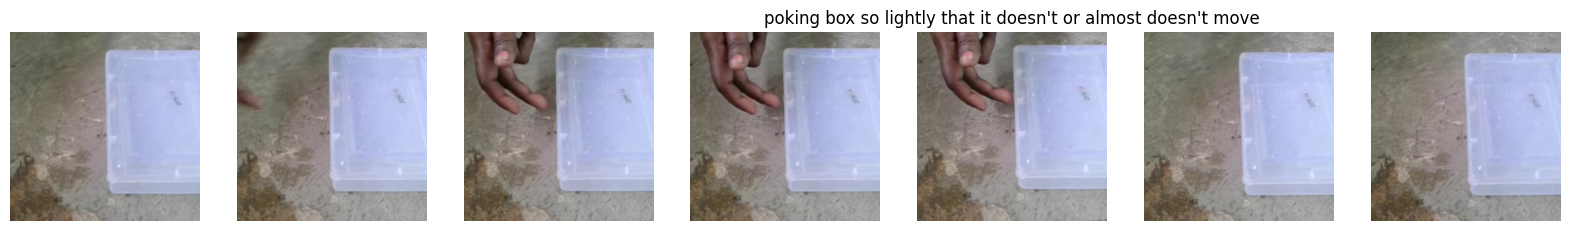

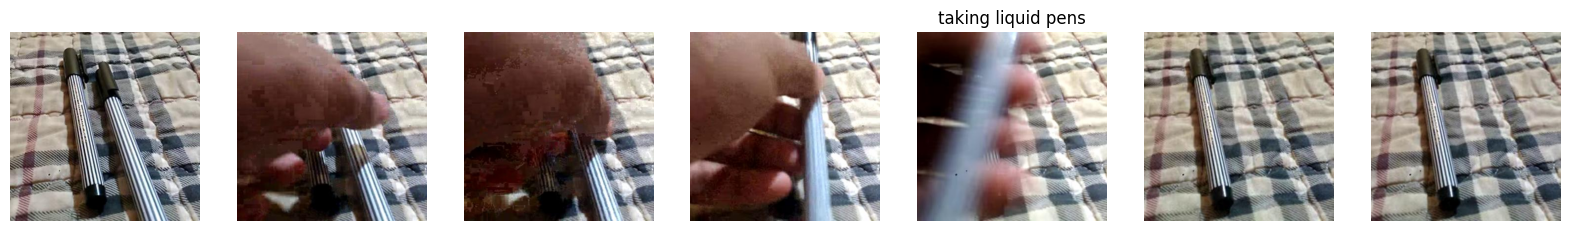

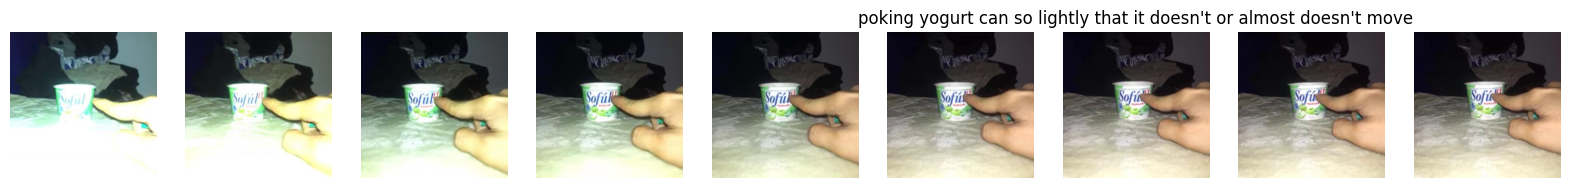

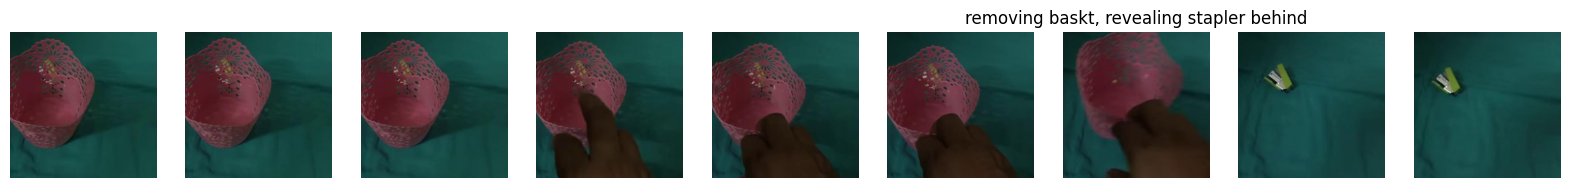

In [27]:
import os
import json
import datasets as hf_datasets
from mmassist.datasets.utils.video_utils import str2img
import matplotlib.pyplot as plt

frames_dir = "/fsx_0/user/imzyc/processed_data/sthsthv2/frames"
frames_files = os.listdir(frames_dir)
frames_file = os.path.join(frames_dir, frames_files[1])
all_frames_in_video = hf_datasets.Dataset.from_file(frames_file)
frame_str = all_frames_in_video[0]["frame"]

ann_file = frames_file.replace(".arrow", ".json").replace("frames", "annotations")
with open(ann_file, "r") as f:
    anns = json.load(f)

import random


for idx in random.sample(range(len(anns["anns"])), 5):
    # plot
    ann = anns["anns"][idx]
    start_idx = ann["frame_start_idx"]
    end_idx = ann["frame_end_idx"]
    frames = [str2img(all_frames_in_video[i]["frame"]) for i in range(start_idx, end_idx)]
    fig, axs = plt.subplots(1, len(frames), figsize=(20, 10))
    print(f"Annotation {idx}: {ann['label']}")
    label_pos = int((len(frames) * 0.75) + 0.5)
    for i, frame in enumerate(frames):
        axs[i].imshow(frame)
        axs[i].axis("off")
        if i + 1 == label_pos:
            axs[i].set_title(ann['label'])
    

In [34]:
anns

{'anns': [{'id': '112839',
   'label': 'touching (without moving) wheel of sewing mechine',
   'template': 'Touching (without moving) [part] of [something]',
   'placeholders': ['wheel', 'sewing mechine'],
   'frame_start_idx': 0,
   'frame_end_idx': 7},
  {'id': '73931',
   'label': 'pretending to take brush from rack',
   'template': 'Pretending to take [something] from [somewhere]',
   'placeholders': ['brush', 'rack'],
   'frame_start_idx': 7,
   'frame_end_idx': 14},
  {'id': '51574',
   'label': 'putting an ashtray on a surface',
   'template': 'Putting [something] on a surface',
   'placeholders': ['an ashtray'],
   'frame_start_idx': 14,
   'frame_end_idx': 19},
  {'id': '195651',
   'label': 'tearing paper just a little bit',
   'template': 'Tearing [something] just a little bit',
   'placeholders': ['paper'],
   'frame_start_idx': 19,
   'frame_end_idx': 25},
  {'id': '182676',
   'label': 'pushing remote from left to right',
   'template': 'Pushing [something] from left to r

In [35]:
from collections import Counter
import os
import json

anns_dir = "/fsx_0/user/imzyc/processed_data/sthsthv2/annotations"
ann_files = os.listdir(anns_dir)

nouns = Counter()
num_pretending = 0
num_normal = 0
for ann_file in ann_files:
    with open(os.path.join(anns_dir, ann_file), "r") as f:
        anns = json.load(f)
    for ann in anns["anns"]:
        label = ann["label"]
        if "pretend" in label:
            num_pretending += 1
        else:
            num_normal += 1
        for n in ann["placeholders"]:
            if n.startswith("a "):
                n = n[2:]
            if n.startswith("an "):
                n = n[3:]
            if n.startswith("the "):
                n = n[4:]
            nouns[n] += 1


print(num_pretending, num_normal, num_pretending / (num_pretending + num_normal)) 

18728 174962 0.0966905880530745


In [11]:
len(nouns)

22534

In [5]:
import os
import datasets as hf_datasets
from mmassist.datasets.utils.video_utils import str2img
import matplotlib.pyplot as plt

frames_dir = "/fsx_0/user/imzyc/processed_data/assembly101/frames"
frames_files = os.listdir(frames_dir)
frames_file = os.path.join(frames_dir, frames_files[1])
all_frames_in_video = hf_datasets.Dataset.from_file(frames_file)
frame_str = all_frames_in_video[0]["frame"]

# plot
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    frame = str2img(all_frames_in_video[i]["frame"])
    axs[i].imshow(frame)
    axs[i].axis("off")
    

## Visuailzed Prepared Data

In [1]:
import os
import datasets as hf_datasets

# data_dir = "/fsx_0/user/imzyc/processed_data/llava"
# data_file = os.path.join(data_dir, "prepared/caption_L2048_I1.jsonl")
# data_dir = "/fsx_0/user/imzyc/processed_data/sthsthv2"
# data_file = os.path.join(data_dir, "prepared/narration_L2048_I1+SEP.jsonl")
data_dir = "/fsx_0/user/imzyc/processed_data/assembly101"
data_file = os.path.join(data_dir, "prepared/dialog_val_L2048_I1+SEP.jsonl")
data = hf_datasets.Dataset.from_json(data_file)

Generating train split: 0 examples [00:00, ? examples/s]

[{'content': "You are a proactive assistant. Predict the user's needs and "
             'provide assistance before being requested.',
  'end': None,
  'labels': None,
  'progress': None,
  'role': 'system',
  'start': None,
  'time': None},
 {'content': None,
  'end': 15,
  'labels': None,
  'progress': None,
  'role': 'frames',
  'start': 11,
  'time': None},
 {'content': 'I want to disassemble this toy water tanker into its component '
             'parts.',
  'end': None,
  'labels': '',
  'progress': None,
  'role': 'user',
  'start': None,
  'time': 7.8},
 {'content': 'Task knowledge: Disassembling a Toy Water Tanker into its '
             'Component Parts\n'
             "1. Remove the wheels from the tanker's chassis.\n"
             "2. Detach the bumper from the tanker's body.\n"
             "3. Separate the cabin from the tanker's body.\n"
             "4. Remove the roof from the tanker's body.\n"
             "5. Detach the light from the tanker's body.\n"
             '

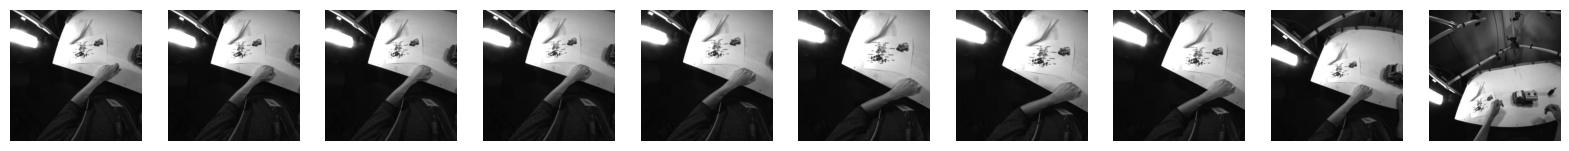

In [8]:
from mmassist.datasets.utils.video_utils import str2img
import matplotlib.pyplot as plt
from pprint import pprint

sample = data[60]
frames_file = os.path.join(data_dir, sample["frames_file"])
all_frames_in_video = hf_datasets.Dataset.from_file(frames_file)
frames = all_frames_in_video[0:10]["frame"]

# plot
pprint(sample["conversation"])
fig, axs = plt.subplots(1, len(frames), figsize=(20, 10))
for i, frame in enumerate(frames):
    pil_img = str2img(frame)
    axs[i].imshow(pil_img)
    axs[i].axis("off")


In [2]:
import json

ann_file = "/fsx_0/user/imzyc/datasets/EgoObjects/EgoObjectsV1_unified_train.json"
with open(ann_file, "r") as f:
    anns = json.load(f)

In [3]:
imageid_to_anns = {}
for ann in anns['annotations']:
    image_id = ann['image_id']
    if image_id not in imageid_to_anns:
        imageid_to_anns[image_id] = []
    imageid_to_anns[image_id].append(ann)

0 578 07 78 939871656701078 1 bottle, mug, light bulb, remote control
0 578 07 78 939871656701078 2 bottle, mug, light bulb, remote control
1 1291 04 12 360110362211334 1 jug
1 1291 04 12 360110362211334 2 jug, spice rack, 2 spice bottles
2 703 01 78 1098951764201859 1 flip-flops, shoes, high heels, sandal
2 703 01 78 1098951764201859 2 flip-flops, shoes, high heels, sandal
3 1234 09 109 1237844653373503 1 table, television stand, computer keyboard, chair, television, laptop, flowerpot, book, mobile phone, house/car key, mouse
3 1234 09 109 1237844653373503 2 table, television stand, computer keyboard, chair, television, laptop, flowerpot, book, box, mobile phone, house/car key, mouse
4 273 10 3 376867011190296 1 table, detergent, water glass
4 273 10 3 376867011190296 2 table, detergent, fork, water glass
5 1551 05 73 1069491826960691 1 table, mixing bowl, spoon, carton
5 1551 05 73 1069491826960691 2 table, mixing bowl, spoon, carton
6 2688 02 67 1117676902382100 1 countertop, stove 

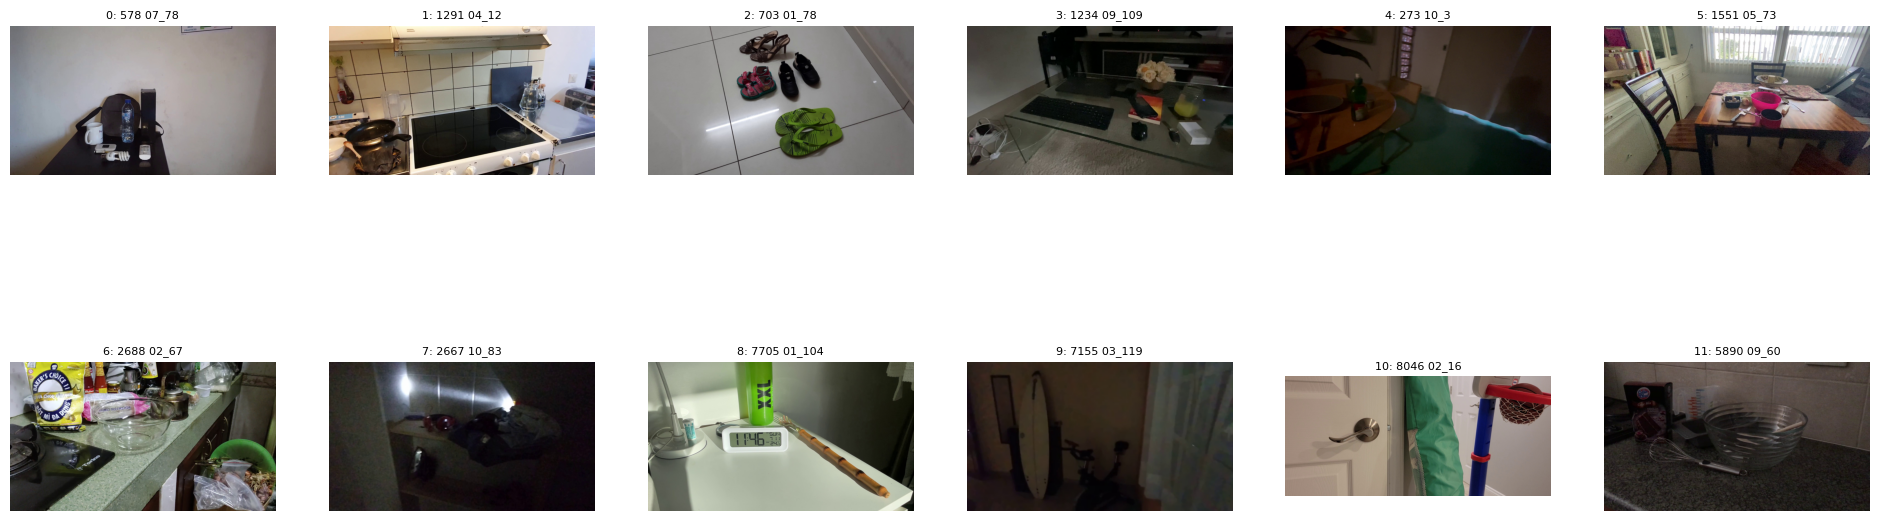

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

img_dir = "/fsx_0/user/imzyc/datasets/EgoObjects/images"
x = 2
fig, axs = plt.subplots(x, 6, figsize=(4*6, 4*x))
axs = axs.flatten()
sorted_images = sorted(anns['images'], key=lambda x: x["url"])

import random

for i in range(x * 6):
    img_idx = i* random.randint(1, 1000) + random.randint(1, 1000)
    img_ann = sorted_images[img_idx]

    video_id = img_ann["video_id"]
    frame_id = img_ann["frame_id"]
    gaia_id = img_ann["gaia_id"]



    h, w = img_ann["height"], img_ann["width"]
    if h > w:
        min_x, max_x = 0, w
        min_y, max_y = (h - w) // 2, (h + w) // 2
    else:
        min_x, max_x = (w - h) // 2, (w + h) // 2
        min_y, max_y = 0, h

    obj_anns = imageid_to_anns[img_ann["id"]]
    obj_anns.sort(key=lambda x: x["area"], reverse=True)
    objects_to_num = {}
    for o in obj_anns:
        x,y,w,h = o["bbox"]
        x1, y1, x2, y2 = x, y, x+w, y+h
        if x2 < min_x or x1 > max_x or y2 < min_y or y1 > max_y:
            continue
        # xc, yc = x + w/2, y + h/2
        # if xc < min_x or xc > max_x or yc < min_y or yc > max_y:
        #     continue
        c = o["category_freeform"]
        if c not in objects_to_num:
            objects_to_num[c] = 0
        objects_to_num[c] += 1
    
    narration = ""
    for o, n in objects_to_num.items():
        if n == 1:
            narration += f"{o}, "
        else:
            o = o+"s" if not o.endswith("s") else o
            narration += f"{n} {o}, "
    narration = narration[:-2]
    print(i, img_idx, video_id, frame_id, gaia_id, "1", narration)

    objects_to_num = {}
    for o in obj_anns:
        c = o["category_freeform"]
        if c not in objects_to_num:
            objects_to_num[c] = 0
        objects_to_num[c] += 1
    
    narration = ""
    for o, n in objects_to_num.items():
        if n == 1:
            narration += f"{o}, "
        else:
            o = o+"s" if not o.endswith("s") else o
            narration += f"{n} {o}, "
    narration = narration[:-2]
    print(i, img_idx, video_id, frame_id, gaia_id, "2", narration)

    img_path = os.path.join(img_dir, img_ann["url"])
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"{i}: {img_idx} {video_id}_{frame_id}", fontsize=8)
    img.close()

In [55]:
a = sorted_images[6551]
img_path = os.path.join(img_dir, a["url"])
img = Image.open(img_path)
obj_anns = imageid_to_anns[a["id"]]

# draw boxes
from PIL import ImageDraw
draw = ImageDraw.Draw(img)

for o in obj_anns:
    x,y,w,h = o["bbox"]
    bbox = [x, y, x+w, y+h]
    draw.rectangle(bbox, outline="red", width=2)
plt.imshow(img)

sorted_images[1551]

{'id': 930279837853553,
 'height': 1080,
 'width': 1920,
 'url': '056F94602648C57BDE51FA93C8A8847D_05_73.jpg',
 'gaia_id': 1069491826960691,
 'timestamp': [1642848380.561076],
 'stream_ids': ['1201-2'],
 'group_id': '056F94602648C57BDE51FA93C8A8847D',
 'video_id': '05',
 'frame_id': 73,
 'main_category': 'spoon',
 'neg_category_ids': [172, 284, 512, 388, 350, 616, 415, 199, 283, 404]}

In [31]:
sorted_images[52]

{'id': 800949684407741,
 'height': 1264,
 'width': 1264,
 'url': '002589BC57A96B5FCCC6CE8FF70B5EE5_04_16.jpg',
 'gaia_id': 573094727687772,
 'timestamp': [1658950496.441702],
 'stream_ids': ['1201-2'],
 'group_id': '002589BC57A96B5FCCC6CE8FF70B5EE5',
 'video_id': '04',
 'frame_id': 16,
 'main_category': 'frying pan',
 'neg_category_ids': [35, 4, 168, 16, 210, 132, 447, 77, 424, 354]}

In [12]:
anns['annotations'][0]

{'id': 1,
 'image_id': 2336139953203985,
 'bbox': [394.25, 600.07, 599.31, 275.62],
 'area': 165181.8222,
 'category_id': 235,
 'is_main': True,
 'category_freeform': 'frying pan',
 'instance_tag': '002589BC57A96B5FCCC6CE8FF70B5EE5_Frying pan(p0)_0',
 'instance_id': 1,
 '_category_id': 235}

In [ ]:
import os,json
import ast
import pandas as pd

goalstep_ann_file = "/nfs/turbo/coe-chaijy-unreplicated/datasets/ego4d/v2/annotations/goalstep_trainval.json"

goalstep_grp_to_vids_file = "/nfs/turbo/coe-chaijy-unreplicated/datasets/ego4d/v2/annotations/goalstep_video_groups.tsv"

vf_to_vfs = {}
video_groups = pd.read_csv(goalstep_grp_to_vids_file, delimiter="\t")
for entry in video_groups.to_dict("records"):
    vg = ast.literal_eval(entry["video_group"])
    vf_to_vfs[vg[0]] = vg


with open(goalstep_ann_file, "r") as f:
    anns = json.load(f)

for ann in anns["videos"]:
    video_id = ann["video_uid"]
    if video_id not in all_vids:
        print(video_id)
